# Motion Segmentation Model - Deep Error Analysis

This notebook provides comprehensive analysis of motion segmentation model performance, focusing on understanding when and why the model makes errors.

## Analysis includes:
- Transition length analysis (short vs long transitions)
- Transition position analysis (beginning, middle, end)
- Sequence length impact
- Confidence/uncertainty analysis
- Temporal error patterns
- Class imbalance effects

In [16]:
import os
import sys
import tqdm
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.metrics import confusion_matrix, classification_report
import warnings

warnings.filterwarnings('ignore')

# Add your project to path
sys.path.append('/home/nadir/tmr-code')

from src.config import read_config
from src.load import load_model_from_cfg
from hydra.utils import instantiate
import pytorch_lightning as pl

In [17]:
RUN_DIR = "/home/nadir/tmr-code/outputs/archives.new/start-end-segmentation_tmr_majority-based-start-end-with-majority_False_mlp_20"
DEVICE = "cuda:1"
CKPT_NAME = "best"
DATA_DIR = "/home/nadir/disk/datasets/babel-for-validation"
MAX_SEQUENCES_TO_ANALYZE = 2048
IOU_DETECTION_THRESHOLD = 0.5

In [18]:
print("[RUN_DIR]:", RUN_DIR)

[RUN_DIR]: /home/nadir/tmr-code/outputs/archives.new/start-end-segmentation_tmr_majority-based-start-end-with-majority_False_mlp_20


In [19]:
cfg = read_config(RUN_DIR)
pl.seed_everything(cfg.seed)

window_size = int(RUN_DIR.split("_mlp_")[1])

model = load_model_from_cfg(cfg, CKPT_NAME, eval_mode=True, device=DEVICE).eval()

dataset = instantiate(
    {
        "_target_": "src.data.windowed_dataset.WindowedDataset",
    },
    dir=DATA_DIR,
    window_size=window_size,
    split="all",
    for_validation=True,
    normalize=False,
    balanced=False
)

normalization_statistics = torch.load(os.path.join(dataset.dir, "motion_normalization_stats.pt"))
mean = normalization_statistics["mean"]
std = normalization_statistics["std"]

print(f"[window-size]: {window_size}")
print(f"[#dataset]: {len(dataset)} sequences.")

Global seed set to 1234


[slef.dir]: /home/nadir/disk/datasets/babel-for-validation/20-1
here


[preloading]: 100%|██████████| 1538/1538 [00:00<00:00, 3749.08it/s]

[window-size]: 20
[#dataset]: 1538 sequences.


In [20]:
vote_manager = instantiate({
    "_target_": "src.model.vote_managers.score-based.ScoreBasedVoteManager"
})

In [21]:
def extract_segments(sequence):
    segments = []
    if len(sequence) == 0:
        return segments
    
    current_label = sequence[0]
    start_idx = 0
    
    for i in range(1, len(sequence)):
        if sequence[i] != current_label:
            segments.append((current_label, start_idx, i))
            start_idx = i
            current_label = sequence[i]
    
    # NOTE: add final segment
    segments.append((current_label, start_idx, len(sequence)))
    return segments

def get_transition_segments(sequence):
    segments = extract_segments(sequence)
    transitions = [(start, end) for label, start, end in segments if label == 1]
    return transitions

def get_segment_position_in_sequence(start, end, total_length):
    center = (start + end) / 2
    relative_pos = center / total_length
    
    if relative_pos < 0.33:
        return 'beginning'
    elif relative_pos < 0.67:
        return 'middle'
    else:
        return 'end'

def categorize_transition_length(length):
    if length <= 5:
        return 'short'
    elif length <= 15:
        return 'medium'
    else:
        return 'long'

def categorize_sequence_length(length):
    if length <= 100:
        return 'short'
    elif length <= 300:
        return 'medium'
    else:
        return 'long'

In [ ]:
results = []
all_predictions = []
all_ground_truth = []
all_confidence_scores = []

with torch.no_grad():
    for idx in tqdm.tqdm(iterable=range(min(len(dataset), MAX_SEQUENCES_TO_ANALYZE)), total=min(len(dataset), MAX_SEQUENCES_TO_ANALYZE), desc="[segmentation-analysis]"):
        sample = dataset[idx]
        
        sample["transformed_motion"] = sample["transformed_motion"].to(DEVICE)
        sample["motion"] = sample["motion"].to(DEVICE)
        sample["transition_mask"] = sample["transition_mask"].to(DEVICE)
        sample["annotation"] = sample["transition_mask"]
        
        ground_truth = sample["transition_mask"].cpu().numpy()
        
        outputs, exception = model.segment_sequence(
            sample,
            window_size=window_size,
            window_step=1,
            vote_manager=vote_manager,
            mean=mean,
            std=std
        )
        
        if exception is not None:
            print(f"[warning]: skipped {idx}: {exception}")
            continue
        
        predictions = outputs.cpu().numpy()
        
        all_predictions.append(predictions)
        all_ground_truth.append(ground_truth)
        
        seq_length = len(ground_truth)
        
        gt_transitions = get_transition_segments(ground_truth)
        pred_transitions = get_transition_segments(predictions)
        
        frame_accuracy = np.mean(predictions == ground_truth)
        
        # NOTE: transition level analysis
        for gt_start, gt_end in gt_transitions:
            gt_length = gt_end - gt_start
            gt_position = get_segment_position_in_sequence(gt_start, gt_end, seq_length)
            
            best_iou = 0
            best_pred_transition = None
            detected = False
            
            for pred_start, pred_end in pred_transitions:
                intersection = max(0, min(gt_end, pred_end) - max(gt_start, pred_start))
                union = max(gt_end, pred_end) - min(gt_start, pred_start)
                iou = intersection / union if union > 0 else 0
                
                if iou > best_iou:
                    best_iou = iou
                    best_pred_transition = (pred_start, pred_end)
                    
                if iou > IOU_DETECTION_THRESHOLD:
                    detected = True
            
            result = {
                'sequence_idx': idx,
                'sequence_length': seq_length,
                'sequence_length_cat': categorize_sequence_length(seq_length),
                'frame_accuracy': frame_accuracy,
                'gt_start': gt_start,
                'gt_end': gt_end,
                'gt_length': gt_length,
                'gt_length_cat': categorize_transition_length(gt_length),
                'gt_position': gt_position,
                'detected': detected,
                'best_iou': best_iou,
                'num_gt_transitions': len(gt_transitions),
                'num_pred_transitions': len(pred_transitions),
            }
            
            if best_pred_transition:
                result['pred_start'] = best_pred_transition[0]
                result['pred_end'] = best_pred_transition[1]
                result['pred_length'] = best_pred_transition[1] - best_pred_transition[0]
                result['pred_length_cat'] = categorize_transition_length(result['pred_length'])
            else:
                result['pred_start'] = None
                result['pred_end'] = None
                result['pred_length'] = None
                result['pred_length_cat'] = None
            
            results.append(result)

print(f"[#transitions-analyzed]: {len(results)}")

df = pd.DataFrame(results)

[segmentation-analysis]:   0%|          | 0/1538 [00:00<?, ?it/s]

## Overall Performance Metrics

In [ ]:
flat_preds = np.concatenate(all_predictions)
flat_gt = np.concatenate(all_ground_truth)

overall_accuracy = np.mean(flat_preds == flat_gt)
confusion = confusion_matrix(flat_gt, flat_preds)
class_report = classification_report(flat_gt, flat_preds, target_names=['Action', 'Transition'], output_dict=True)

print(f"[frame-wise-accuracy]: {overall_accuracy:.3f}")
print(f"--- --- ---")
print(f"[action-class-accuracy]: {class_report['Action']['recall']:.3f}")
print(f"--- --- ---")
print(f"[transition-class-accuracy]: {class_report['Transition']['recall']:.3f}")
print(f"[transition-class-precision]: {class_report['Transition']['precision']:.3f}")
print(f"[transition-class-f1]: {class_report['Transition']['f1-score']:.3f}")

print()

# NOTE: transition detection rate
detection_rate = df['detected'].mean()
print(f"[transition-(IoU > {IOU_DETECTION_THRESHOLD})]: {detection_rate:.3f}")

# NOTE: average IoU for detected transitions
avg_iou_detected = df[df['detected']]['best_iou'].mean()
print(f"[average-iou-for-detected-transitions]: {avg_iou_detected:.3f}")

# NOTE: transition-count-accuracy
transition_count_accuracy = []
for preds, gt in zip(all_predictions, all_ground_truth):
    gt_count = len(get_transition_segments(gt))
    pred_count = len(get_transition_segments(preds))
    if gt_count > 0:
        accuracy = 1.0 - abs(pred_count - gt_count) / gt_count
    else:
        accuracy = 1.0 if pred_count == 0 else 0.0
    transition_count_accuracy.append(accuracy)

print(f"[transition-count-accuracy]: {np.mean(transition_count_accuracy):.3f}")

[frame-wise-accuracy]: 0.885
--- --- ---
[action-class-accuracy]: 0.962
--- --- ---
[transition-class-accuracy]: 0.195
[transition-class-precision]: 0.364
[transition-class-f1]: 0.254

[transition-(IoU > 0.5)]: 0.105
[average-iou-for-detected-transitions]: 0.704
[transition-count-accuracy]: 0.600


<div class="alert alert-info">

#### **Confusion Matrix**

Below we do the confusion matrix of the falttened ground truth and predictions.

</div>

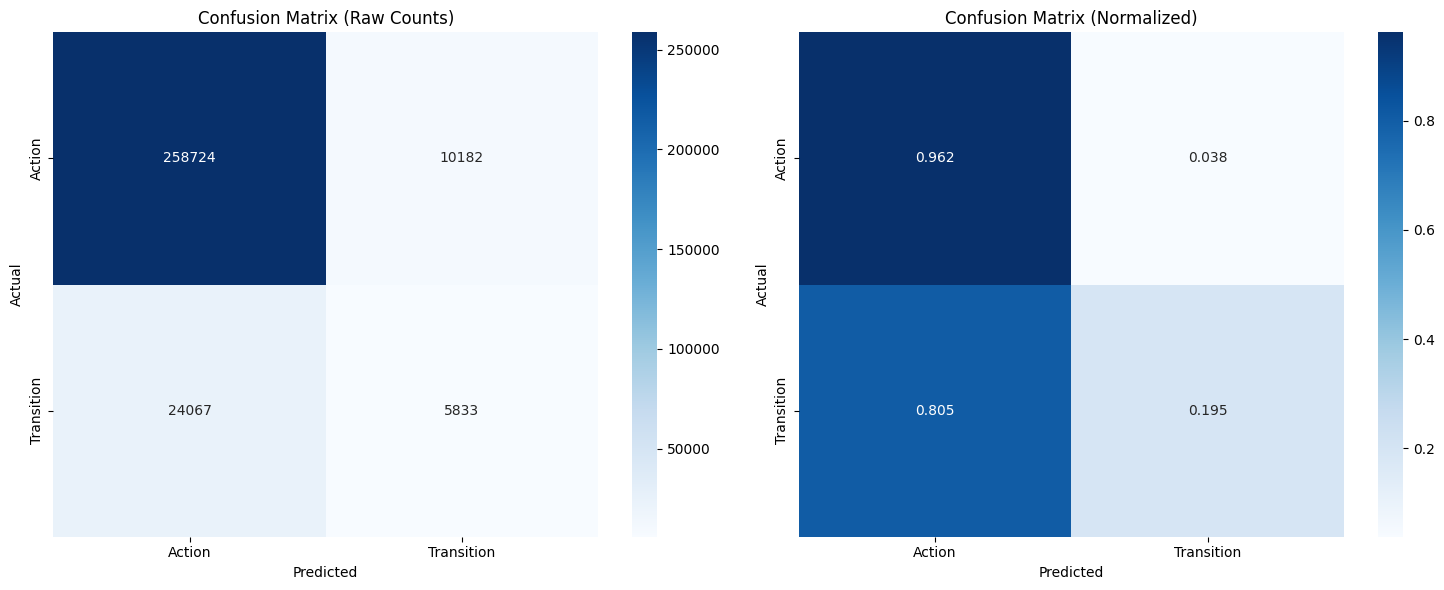

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

sns.heatmap(
    confusion,
    annot=True,
    fmt='d',
    cmap='Blues',
    ax=ax1,
    xticklabels=['Action', 'Transition'], 
    yticklabels=['Action', 'Transition']
)
ax1.set_title('Confusion Matrix (Raw Counts)')
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Actual')

confusion_norm = confusion.astype('float') / confusion.sum(axis=1)[:, np.newaxis]
sns.heatmap(
    confusion_norm,
    annot=True,
    fmt='.3f',
    cmap='Blues',
    ax=ax2,
    xticklabels=['Action', 'Transition'], 
    yticklabels=['Action', 'Transition']
)
ax2.set_title('Confusion Matrix (Normalized)')
ax2.set_xlabel('Predicted')
ax2.set_ylabel('Actual')

plt.tight_layout()
plt.show()

<div class="alert alert-info">

#### **Error Analysis by Transition Characteristics**

</div>

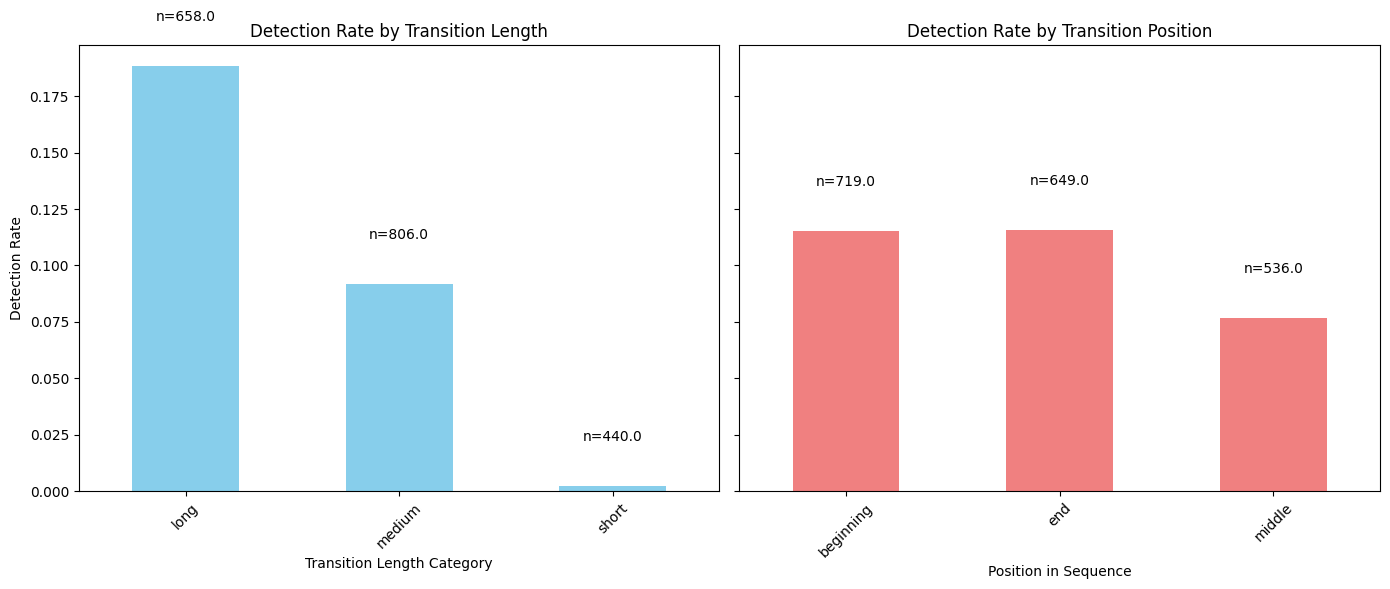

Detection Rate by Transition Length:
                   mean  count
gt_length_cat                 
long           0.188450    658
medium         0.091811    806
short          0.002273    440

Detection Rate by Transition Position:
                 mean  count
gt_position                 
beginning    0.115438    719
end          0.115562    649
middle       0.076493    536


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

detection_by_length = df.groupby('gt_length_cat')['detected'].agg(['mean', 'count'])
ax1 = axes[0]
detection_by_length['mean'].plot(kind='bar', ax=ax1, color='skyblue')
ax1.set_title('Detection Rate by Transition Length')
ax1.set_ylabel('Detection Rate')
ax1.set_xlabel('Transition Length Category')
ax1.tick_params(axis='x', rotation=45)
for i, (idx, row) in enumerate(detection_by_length.iterrows()):
    ax1.text(i, row['mean'] + 0.02, f'n={row["count"]}', ha='center')

detection_by_position = df.groupby('gt_position')['detected'].agg(['mean', 'count'])
ax2 = axes[1]
detection_by_position['mean'].plot(kind='bar', ax=ax2, color='lightcoral')
ax2.set_title('Detection Rate by Transition Position')
ax2.set_xlabel('Position in Sequence')
ax2.tick_params(axis='x', rotation=45)
for i, (idx, row) in enumerate(detection_by_position.iterrows()):
    ax2.text(i, row['mean'] + 0.02, f'n={row["count"]}', ha='center')

plt.tight_layout()
plt.show()

print("Detection Rate by Transition Length:")
print(detection_by_length)

print("\nDetection Rate by Transition Position:")
print(detection_by_position)

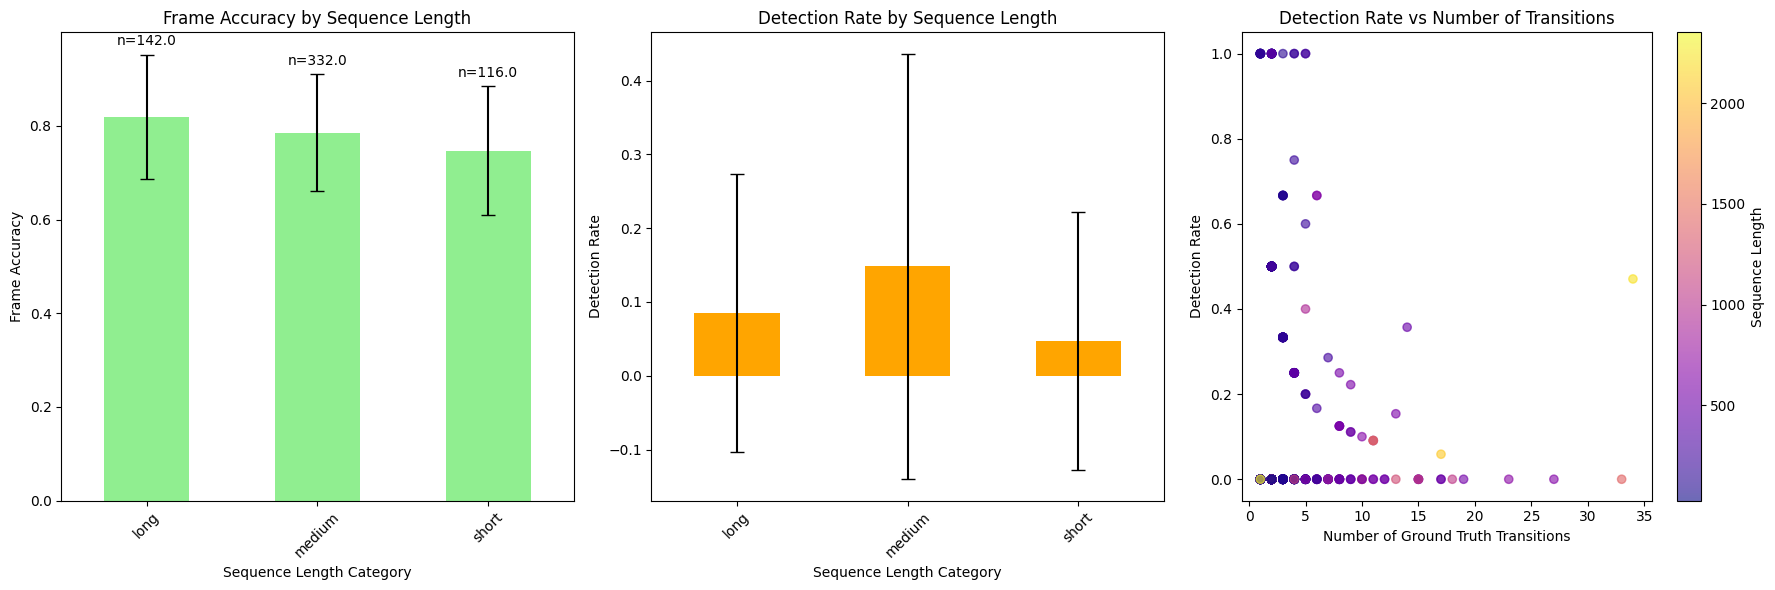

Frame Accuracy by Sequence Length:
                         mean       std  count
sequence_length_cat                           
long                 0.819605  0.132415    142
medium               0.785501  0.124300    332
short                0.747135  0.137287    116

Detection Rate by Sequence Length:
                         mean       std  count
sequence_length_cat                           
long                 0.084834  0.188371    142
medium               0.148183  0.288288    332
short                0.046695  0.174556    116


In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

seq_stats = df.groupby('sequence_idx').agg({
    'sequence_length': 'first',
    'sequence_length_cat': 'first',
    'frame_accuracy': 'first',
    'num_gt_transitions': 'first',
    'detected': 'mean'
}).reset_index()

frame_acc_by_seq_length = seq_stats.groupby('sequence_length_cat')['frame_accuracy'].agg(['mean', 'std', 'count'])
ax1 = axes[0]
frame_acc_by_seq_length['mean'].plot(kind='bar', ax=ax1, yerr=frame_acc_by_seq_length['std'], 
                                     capsize=5, color='lightgreen')
ax1.set_title('Frame Accuracy by Sequence Length')
ax1.set_ylabel('Frame Accuracy')
ax1.set_xlabel('Sequence Length Category')
ax1.tick_params(axis='x', rotation=45)

for i, (idx, row) in enumerate(frame_acc_by_seq_length.iterrows()):
    ax1.text(i, row['mean'] + row['std'] + 0.02, f'n={row["count"]}', ha='center')

detection_by_seq_length = seq_stats.groupby('sequence_length_cat')['detected'].agg(['mean', 'std', 'count'])
ax2 = axes[1]
detection_by_seq_length['mean'].plot(kind='bar', ax=ax2, yerr=detection_by_seq_length['std'], 
                                     capsize=5, color='orange')
ax2.set_title('Detection Rate by Sequence Length')
ax2.set_ylabel('Detection Rate')
ax2.set_xlabel('Sequence Length Category')
ax2.tick_params(axis='x', rotation=45)

ax3 = axes[2]
scatter2 = ax3.scatter(seq_stats['num_gt_transitions'], seq_stats['detected'], 
                       alpha=0.6, c=seq_stats['sequence_length'], cmap='plasma')
ax3.set_title('Detection Rate vs Number of Transitions')
ax3.set_xlabel('Number of Ground Truth Transitions')
ax3.set_ylabel('Detection Rate')
plt.colorbar(scatter2, ax=ax3, label='Sequence Length')

plt.tight_layout()
plt.show()

print("Frame Accuracy by Sequence Length:")
print(frame_acc_by_seq_length)
print("\nDetection Rate by Sequence Length:")
print(detection_by_seq_length)

## Detailed Error Patterns Analysis

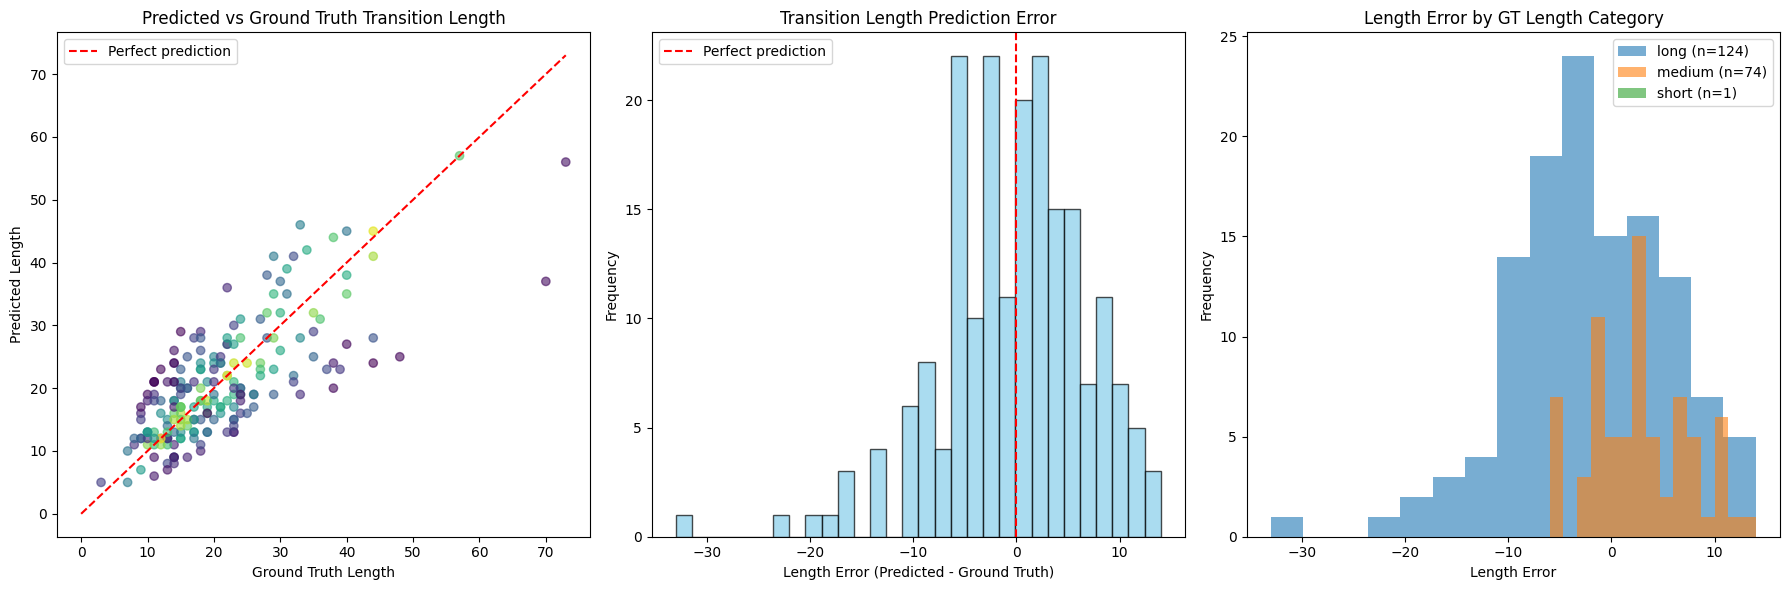

Mean length error: -0.33
Std length error: 7.13
Median length error: 0.00

Length error by category:
long: mean=-2.10, std=7.75
medium: mean=2.61, std=4.75
short: mean=2.00, std=nan


In [ ]:
detected_transitions = df[df['detected'] & df['pred_length'].notna()].copy()

if len(detected_transitions) > 0:
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Scatter plot: predicted vs ground truth length
    ax1 = axes[0]
    ax1.scatter(detected_transitions['gt_length'], detected_transitions['pred_length'], 
               alpha=0.6, c=detected_transitions['best_iou'], cmap='viridis')
    ax1.plot([0, detected_transitions['gt_length'].max()], [0, detected_transitions['gt_length'].max()], 
            'r--', label='Perfect prediction')
    ax1.set_xlabel('Ground Truth Length')
    ax1.set_ylabel('Predicted Length')
    ax1.set_title('Predicted vs Ground Truth Transition Length')
    ax1.legend()
    
    # Length error distribution
    length_error = detected_transitions['pred_length'] - detected_transitions['gt_length']
    ax2 = axes[1]
    ax2.hist(length_error, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
    ax2.axvline(0, color='red', linestyle='--', label='Perfect prediction')
    ax2.set_xlabel('Length Error (Predicted - Ground Truth)')
    ax2.set_ylabel('Frequency')
    ax2.set_title('Transition Length Prediction Error')
    ax2.legend()
    
    # Length error by ground truth length category
    ax3 = axes[2]
    for length_cat in detected_transitions['gt_length_cat'].unique():
        if pd.notna(length_cat):
            subset_error = length_error[detected_transitions['gt_length_cat'] == length_cat]
            ax3.hist(subset_error, alpha=0.6, label=f'{length_cat} (n={len(subset_error)})', bins=15)
    ax3.set_xlabel('Length Error')
    ax3.set_ylabel('Frequency')
    ax3.set_title('Length Error by GT Length Category')
    ax3.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Statistics
    print(f"Mean length error: {length_error.mean():.2f}")
    print(f"Std length error: {length_error.std():.2f}")
    print(f"Median length error: {length_error.median():.2f}")
    print(f"\nLength error by category:")
    for cat in detected_transitions['gt_length_cat'].unique():
        if pd.notna(cat):
            cat_error = length_error[detected_transitions['gt_length_cat'] == cat]
            print(f"{cat}: mean={cat_error.mean():.2f}, std={cat_error.std():.2f}")
else:
    print("No detected transitions found for length analysis")

## False Positive and False Negative Analysis

Analyzing False Positives and False Negatives...


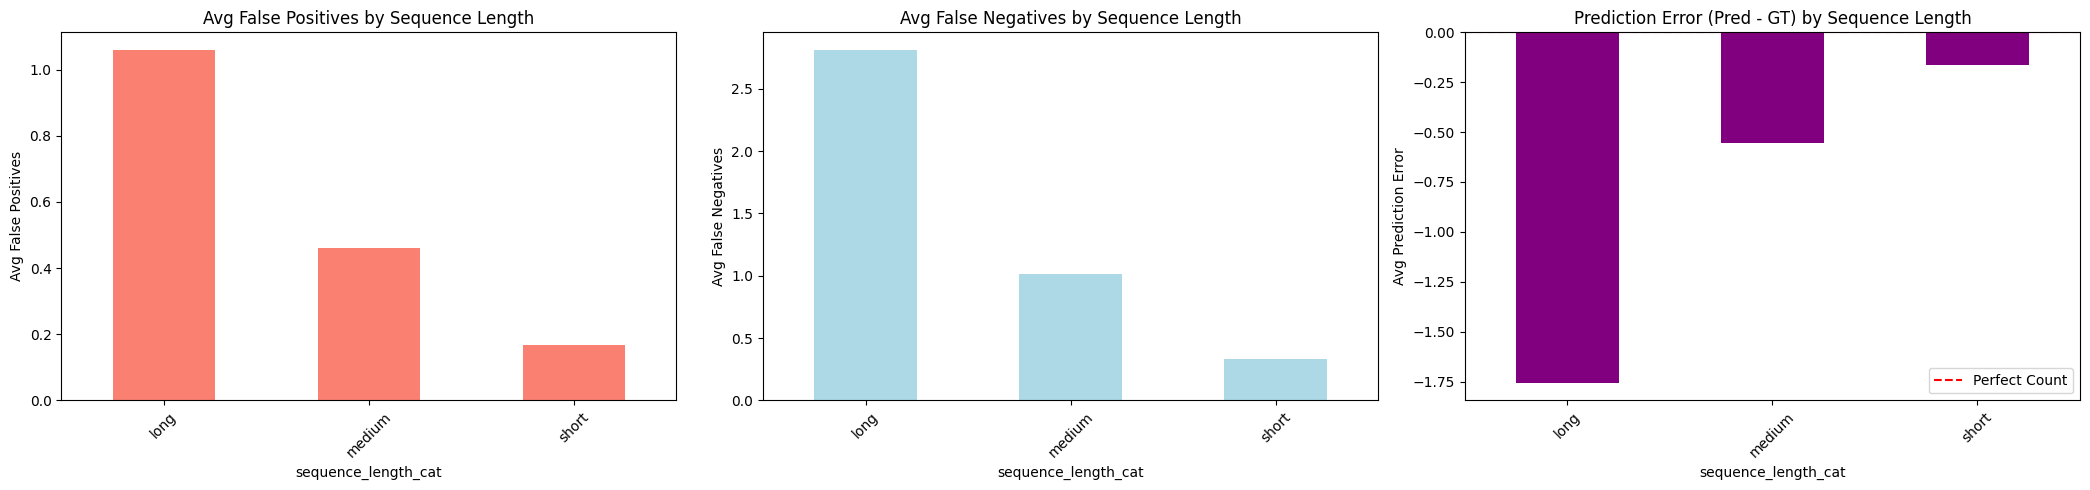

Total sequences analyzed: 1528
Average false positives per sequence: 0.44
Average false negatives per sequence: 1.04

Sequences with no errors: 782
Sequences with only FP: 198
Sequences with only FN: 321
Sequences with both FP and FN: 227


In [ ]:
# Analyze false positives and false negatives
print("Analyzing False Positives and False Negatives...")

# Calculate sequence-level statistics
sequence_analysis = []

for seq_idx in range(len(all_predictions)):
    gt = all_ground_truth[seq_idx]
    pred = all_predictions[seq_idx]
    
    # Get segments
    gt_segments = extract_segments(gt)
    pred_segments = extract_segments(pred)
    
    gt_transitions = [(start, end) for label, start, end in gt_segments if label == 1]
    pred_transitions = [(start, end) for label, start, end in pred_segments if label == 1]
    
    # Calculate false positives (predicted transitions not in ground truth)
    false_positives = []
    for pred_start, pred_end in pred_transitions:
        matched = False
        for gt_start, gt_end in gt_transitions:
            intersection = max(0, min(pred_end, gt_end) - max(pred_start, gt_start))
            union = max(pred_end, gt_end) - min(pred_start, gt_start)
            iou = intersection / union if union > 0 else 0
            if iou > 0.3:
                matched = True
                break
        if not matched:
            false_positives.append((pred_start, pred_end))
    
    # Calculate false negatives (ground truth transitions not predicted)
    false_negatives = []
    for gt_start, gt_end in gt_transitions:
        matched = False
        for pred_start, pred_end in pred_transitions:
            intersection = max(0, min(pred_end, gt_end) - max(pred_start, gt_start))
            union = max(pred_end, gt_end) - min(pred_start, gt_start)
            iou = intersection / union if union > 0 else 0
            if iou > 0.3:
                matched = True
                break
        if not matched:
            false_negatives.append((gt_start, gt_end))
    
    sequence_analysis.append({
        'sequence_idx': seq_idx,
        'sequence_length': len(gt),
        'sequence_length_cat': categorize_sequence_length(len(gt)),
        'num_gt_transitions': len(gt_transitions),
        'num_pred_transitions': len(pred_transitions),
        'num_false_positives': len(false_positives),
        'num_false_negatives': len(false_negatives),
        'false_positives': false_positives,
        'false_negatives': false_negatives
    })

seq_df = pd.DataFrame(sequence_analysis)

# Compute precision and recall
seq_df['precision'] = seq_df.apply(lambda row: 
    (row['num_pred_transitions'] - row['num_false_positives']) / row['num_pred_transitions'] 
    if row['num_pred_transitions'] > 0 else 0, axis=1)

seq_df['recall'] = seq_df.apply(lambda row: 
    (row['num_gt_transitions'] - row['num_false_negatives']) / row['num_gt_transitions'] 
    if row['num_gt_transitions'] > 0 else 1, axis=1)

# Bar plots only - all in one row
fig, axes = plt.subplots(1, 3, figsize=(21, 5))

# False positive rate by sequence length
fp_by_length = seq_df.groupby('sequence_length_cat').agg({
    'num_false_positives': 'mean'
})
ax1 = axes[0]
fp_by_length['num_false_positives'].plot(kind='bar', ax=ax1, color='salmon')
ax1.set_title('Avg False Positives by Sequence Length')
ax1.set_ylabel('Avg False Positives')
ax1.tick_params(axis='x', rotation=45)

# False negative rate by sequence length
fn_by_length = seq_df.groupby('sequence_length_cat').agg({
    'num_false_negatives': 'mean'
})
ax2 = axes[1]
fn_by_length['num_false_negatives'].plot(kind='bar', ax=ax2, color='lightblue')
ax2.set_title('Avg False Negatives by Sequence Length')
ax2.set_ylabel('Avg False Negatives')
ax2.tick_params(axis='x', rotation=45)

# Prediction error (over/under) by sequence length
over_under = seq_df.groupby('sequence_length_cat').apply(
    lambda df: (df['num_pred_transitions'] - df['num_gt_transitions']).mean()
)
ax3 = axes[2]
over_under.plot(kind='bar', ax=ax3, color='purple')
ax3.axhline(0, color='red', linestyle='--', label='Perfect Count')
ax3.set_title('Prediction Error (Pred - GT) by Sequence Length')
ax3.set_ylabel('Avg Prediction Error')
ax3.tick_params(axis='x', rotation=45)
ax3.legend()

plt.tight_layout()
plt.show()

# Print statistics
print(f"Total sequences analyzed: {len(seq_df)}")
print(f"Average false positives per sequence: {seq_df['num_false_positives'].mean():.2f}")
print(f"Average false negatives per sequence: {seq_df['num_false_negatives'].mean():.2f}")
print(f"\nSequences with no errors: {len(seq_df[(seq_df['num_false_positives'] == 0) & (seq_df['num_false_negatives'] == 0)])}")
print(f"Sequences with only FP: {len(seq_df[(seq_df['num_false_positives'] > 0) & (seq_df['num_false_negatives'] == 0)])}")
print(f"Sequences with only FN: {len(seq_df[(seq_df['num_false_positives'] == 0) & (seq_df['num_false_negatives'] > 0)])}")
print(f"Sequences with both FP and FN: {len(seq_df[(seq_df['num_false_positives'] > 0) & (seq_df['num_false_negatives'] > 0)])}")

Analyzing False Positives and False Negatives...


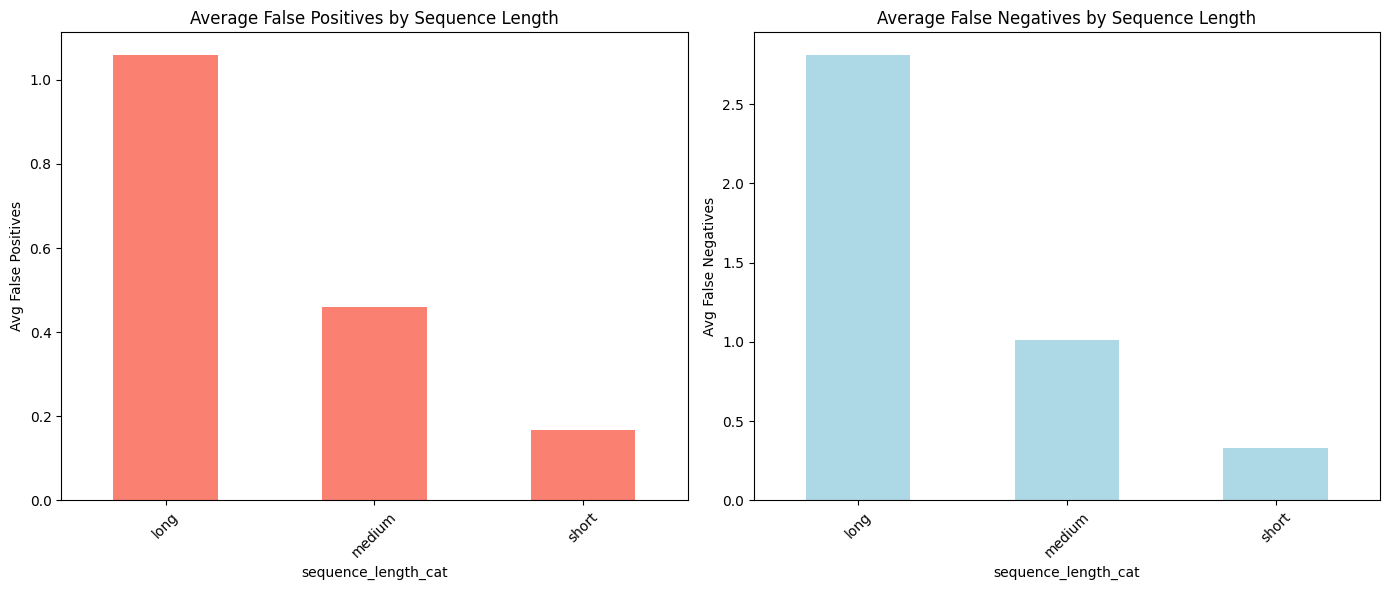

Total sequences analyzed: 1528
Average false positives per sequence: 0.44
Average false negatives per sequence: 1.04

Sequences with no errors: 782
Sequences with only FP: 198
Sequences with only FN: 321
Sequences with both FP and FN: 227


In [ ]:
# Analyze false positives and false negatives
print("Analyzing False Positives and False Negatives...")

# Calculate sequence-level statistics
sequence_analysis = []

for seq_idx in range(len(all_predictions)):
    gt = all_ground_truth[seq_idx]
    pred = all_predictions[seq_idx]

    # Get segments
    gt_segments = extract_segments(gt)
    pred_segments = extract_segments(pred)

    gt_transitions = [(start, end) for label, start, end in gt_segments if label == 1]
    pred_transitions = [(start, end) for label, start, end in pred_segments if label == 1]

    # Calculate false positives (predicted transitions not in ground truth)
    false_positives = []
    for pred_start, pred_end in pred_transitions:
        matched = False
        for gt_start, gt_end in gt_transitions:
            # Check overlap
            intersection = max(0, min(pred_end, gt_end) - max(pred_start, gt_start))
            union = max(pred_end, gt_end) - min(pred_start, gt_start)
            iou = intersection / union if union > 0 else 0
            if iou > 0.3:
                matched = True
                break
        if not matched:
            false_positives.append((pred_start, pred_end))

    # Calculate false negatives (ground truth transitions not predicted)
    false_negatives = []
    for gt_start, gt_end in gt_transitions:
        matched = False
        for pred_start, pred_end in pred_transitions:
            intersection = max(0, min(pred_end, gt_end) - max(pred_start, gt_start))
            union = max(pred_end, gt_end) - min(pred_start, gt_start)
            iou = intersection / union if union > 0 else 0
            if iou > 0.3:
                matched = True
                break
        if not matched:
            false_negatives.append((gt_start, gt_end))

    sequence_analysis.append({
        'sequence_idx': seq_idx,
        'sequence_length': len(gt),
        'sequence_length_cat': categorize_sequence_length(len(gt)),
        'num_gt_transitions': len(gt_transitions),
        'num_pred_transitions': len(pred_transitions),
        'num_false_positives': len(false_positives),
        'num_false_negatives': len(false_negatives),
        'false_positives': false_positives,
        'false_negatives': false_negatives
    })

seq_df = pd.DataFrame(sequence_analysis)

# Visualize false positive/negative patterns (bar plots only)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# False positive rate by sequence length
fp_by_length = seq_df.groupby('sequence_length_cat').agg({
    'num_false_positives': 'mean',
    'sequence_idx': 'count'
})
ax1 = axes[0]
fp_by_length['num_false_positives'].plot(kind='bar', ax=ax1, color='salmon')
ax1.set_title('Average False Positives by Sequence Length')
ax1.set_ylabel('Avg False Positives')
ax1.tick_params(axis='x', rotation=45)

# False negative rate by sequence length
fn_by_length = seq_df.groupby('sequence_length_cat').agg({
    'num_false_negatives': 'mean',
    'sequence_idx': 'count'
})
ax2 = axes[1]
fn_by_length['num_false_negatives'].plot(kind='bar', ax=ax2, color='lightblue')
ax2.set_title('Average False Negatives by Sequence Length')
ax2.set_ylabel('Avg False Negatives')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Print statistics
print(f"Total sequences analyzed: {len(seq_df)}")
print(f"Average false positives per sequence: {seq_df['num_false_positives'].mean():.2f}")
print(f"Average false negatives per sequence: {seq_df['num_false_negatives'].mean():.2f}")
print(f"\nSequences with no errors: {len(seq_df[(seq_df['num_false_positives'] == 0) & (seq_df['num_false_negatives'] == 0)])}")
print(f"Sequences with only FP: {len(seq_df[(seq_df['num_false_positives'] > 0) & (seq_df['num_false_negatives'] == 0)])}")
print(f"Sequences with only FN: {len(seq_df[(seq_df['num_false_positives'] == 0) & (seq_df['num_false_negatives'] > 0)])}")
print(f"Sequences with both FP and FN: {len(seq_df[(seq_df['num_false_positives'] > 0) & (seq_df['num_false_negatives'] > 0)])}")